Starting training for the all-to-all network...


/tmp/ipykernel_72808/3539521245.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[0, input_neuron_idx] = y_train[step-1]
/tmp/ipykernel_72808/3539521245.py:101: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c[0, output_neuron_idx] = initial_credit


Step: 999, Avg Loss: 0.293776
Step: 1998, Avg Loss: 0.022423
Step: 2997, Avg Loss: 0.313864
Step: 3996, Avg Loss: 0.021929
Step: 4995, Avg Loss: 0.316803
Step: 5994, Avg Loss: 0.022970
Step: 6993, Avg Loss: 0.321177
Step: 7992, Avg Loss: 0.023728
Step: 8991, Avg Loss: 0.324520
Step: 9990, Avg Loss: 0.024259
Run 0
Training finished.


ValueError: object too deep for desired array

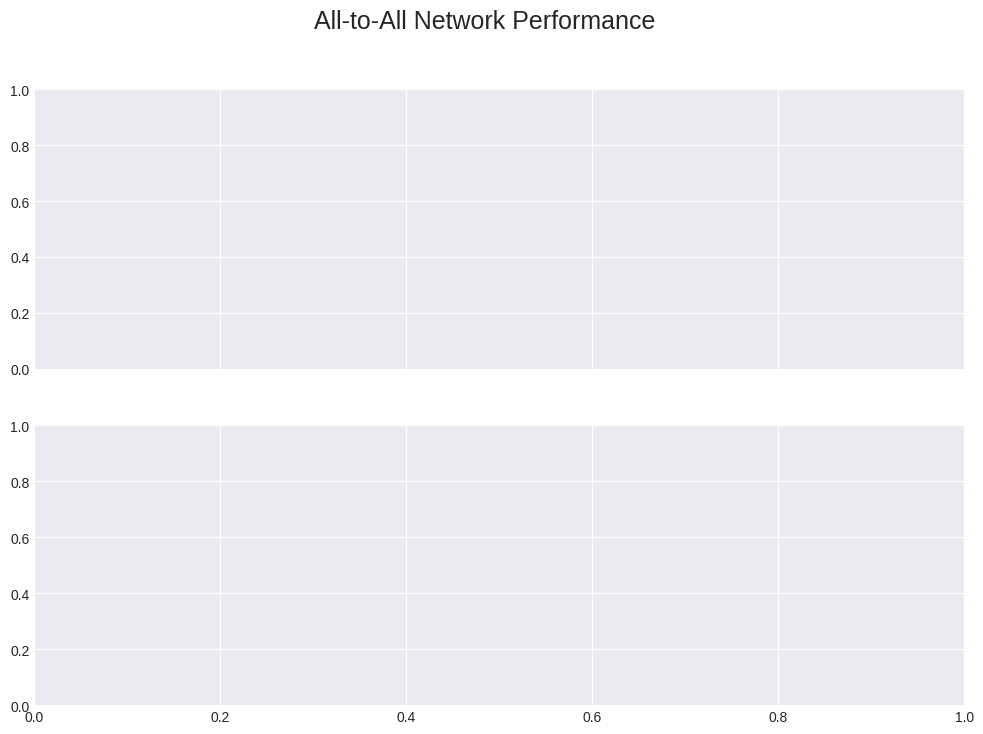

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def tanh(x):
    """Tanh activation function""" 
    return np.tanh(x)

def tanh_der(x):
    return 1 - tanh(x)**2

def sigmoid(x):
    """Sigmoid activation function."""
    return 1 / (1 + np.exp(-x))

def sig_der(x):
    """Derivative of the sigmoid function."""
    s_activated = sigmoid(x)
    return s_activated * (1 - s_activated)

# 1. --- NETWORK AND SIMULATION SETUP ---
# Hyperparameters
num_neurons = 300
learning_rate = 0.05
firing_iterations = 40  # Timesteps for firing rates to stabilize
credit_iterations = 40  # Timesteps for credits to stabilize

# Neuron indices
# We designate specific neurons to handle input and output.
input_neuron_idx = 0
output_neuron_idx = 1
# All other neurons are "hidden".

# 2. --- DATA SETUP ---
x_train = np.linspace(0, 10 * np.pi, 10000) 
y_train = (np.sin(x_train) + 1) / 2 # Normalize sine wave to be in [0, 1] range of sigmoid
# y_train = np.sin(x_train)
x_train = (x_train % (2 * np.pi)) / (2 * np.pi) # Normalize input to [0, 1]

x_train = x_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

# 3. --- NETWORK INITIALIZATION ---
# For an all-to-all network, we have one square weight matrix.
W = np.random.randn(num_neurons, num_neurons) * 0.1

# State vectors for neuron activations (x) and credits (c)
x = np.random.rand(1, num_neurons) * 0.1
c = np.zeros((1, num_neurons))

# History for plotting
err_history = []
y_pred_history = []

print("Starting training for the all-to-all network...")

# 4. --- TRAINING LOOP ---
for run in range(1):
    for step in range(1, len(x_train)):
        
        # --- A) FIRING PHASE: Find equilibrium for x ---
        # The network settles into a stable firing pattern based on the input.
        
        for _ in range(firing_iterations):
            # Clamp the input neuron to the current training sample
            x[0, input_neuron_idx] = y_train[step-1]
             
            # Calculate pre-activations for all neurons
            s = x @ W
            
            # Update all neuron activations
            x = sigmoid(s)

        # After stabilizing, the activity of the output neuron is our prediction
        prediction = x[0, output_neuron_idx]
        y_pred_history.append(prediction)
        
        # Calculate loss for this step
        loss = 0.5 * (y_train[step] - prediction)**2
        err_history.append(loss)

        # --- B) CREDIT ASSIGNMENT PHASE: Find equilibrium for c ---
        # Credits are propagated backward from the output neuron's error signal.
        
        # Reset credits
        c.fill(0)
        
        # This is the initial credit "c(0)" from the paper.
        # It's the error signal clamped onto the output neuron.
        initial_credit = (y_train[step] - prediction)*1
        
        # The balance function f(s) for all neurons, based on their stable pre-activation s
        f_s = sig_der(s)
        
        # The J matrix from the paper (J_ji = f(s_i) * w_ij) governs credit flow.
        # We use its transpose for propagation: c(t+1) = c(t) @ J^T
        # J_transpose_ij = f(s_j) * w_ij
        J_transpose = W * f_s # Element-wise multiplication

        for _ in range(credit_iterations):
            # Clamp the credit of the output neuron
            c[0, output_neuron_idx] = initial_credit
            
            # Propagate credits through the network
            c = c @ J_transpose

        # --- C) NEUROPLASTICITY PHASE: Update weights ---
        # Update weights based on stable activities (x) and stable credits (c).
        # The update rule is Δw_ij = c_i * f(s_i) * x_j
        
        # Reshape for outer product:
        # x is (1, N), c_times_f is (1, N)
        # x.T @ c_times_f gives an (N, N) matrix for the update.
        c_times_f = c * f_s
        delta_W = learning_rate * (x.T @ c_times_f)
        
        W += delta_W

        if step % 999 == 0 and step > 0:
            print(f"Step: {step}, Avg Loss: {np.mean(err_history[-1000:]):.6f}")
    print(f"Run {run}")

print("Training finished.")

# 5. --- VISUALIZE RESULTS ---
plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.suptitle("All-to-All Network Performance", fontsize=18)

lss = err_history[-1000:]
# window_size = 3  # You can adjust the window size as needed
# smoothed_errors = np.convolve(err_history, np.ones(window_size)/window_size, mode='valid')
# Plot loss over time
ax1.plot(err_history, color='crimson', alpha=0.8, linewidth=1)
ax1.set_title("Training Loss Over Time")
ax1.set_ylabel("Mean Squared Error")
ax1.set_yscale('log')

yp = y_pred_history[-1000:]
# Plot the true vs. predicted sine wave
ax2.plot(y_train, label='True Sine Wave', color='dodgerblue', linewidth=2)
ax2.plot(y_pred_history, label='Predicted Output', color='orange', linestyle='--', alpha=0.9)
ax2.set_title("True vs. Predicted Output")
ax2.set_xlabel("Training Step")
ax2.set_ylabel("Value")
ax2.legend()
ax2.set_ylim(-1.1, 1.1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Starting training...


/tmp/ipykernel_6822/532898880.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1[0, 0] = x_train[step]
/tmp/ipykernel_6822/532898880.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1[0, 1] = x_train[step-1]


Step: 9999, Avg Loss: 0.2500
Step: 9999, Avg Loss: 0.2500
Step: 9999, Avg Loss: 0.2500
Step: 9999, Avg Loss: 0.2500
Step: 9999, Avg Loss: 0.2500
Step: 9999, Avg Loss: 0.2500
Step: 9999, Avg Loss: 0.2500
Step: 9999, Avg Loss: 0.2500
Step: 9999, Avg Loss: 0.2500
Step: 9999, Avg Loss: 0.2500
Training finished.


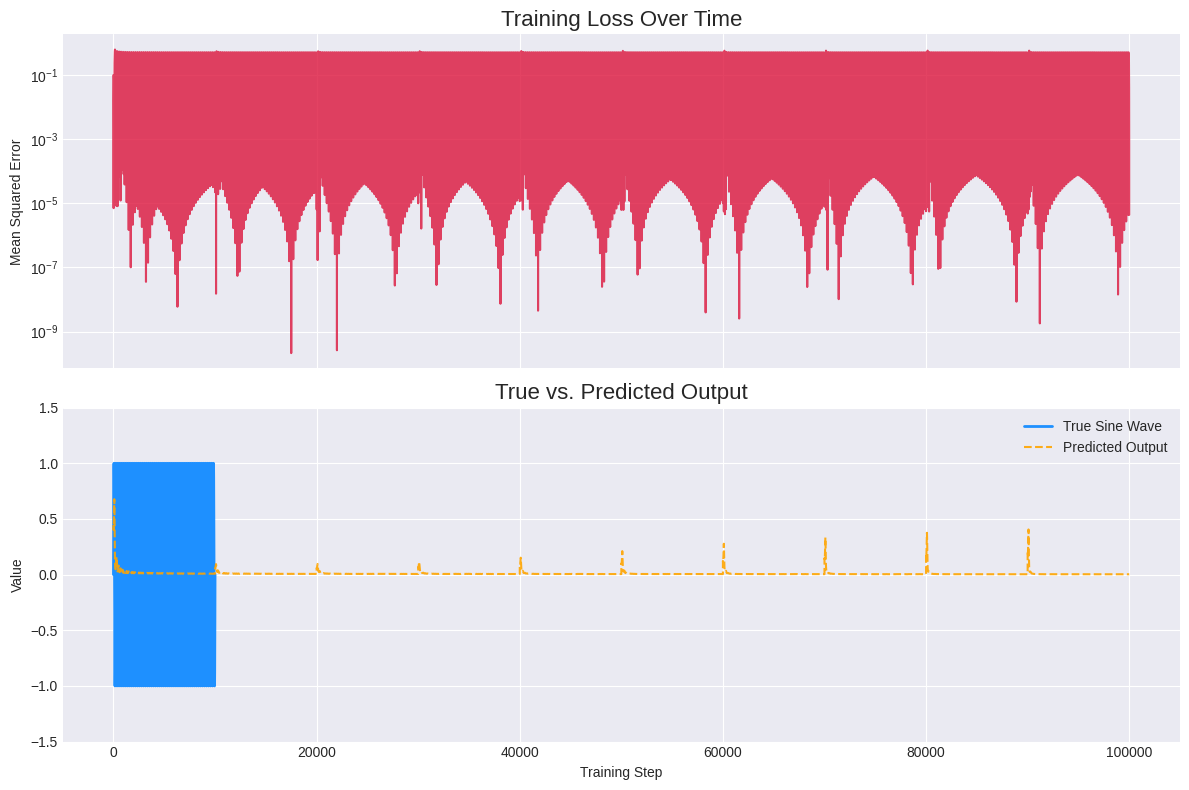

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    """Sigmoid activation function."""
    return 1 / (1 + np.exp(-x))

def sig_der(x):
    """Derivative of the sigmoid function."""
    # Note: This takes the *pre-activation* value 's' as input.
    s_activated = sigmoid(x)
    return s_activated * (1 - s_activated)

# 1. --- DATA SETUP ---
# Generate a sine wave as the training data.
x_train = np.linspace(0, 100 * np.pi, 10000) 
y_train = np.sin(x_train)

# Reshape for matrix operations.
x_train = x_train.reshape(-1, 1)

# 2. --- NETWORK INITIALIZATION ---
# Neuron states (activations)
x1 = np.zeros((1, 2))  # Input layer: [current_sample, previous_sample]
x2 = np.zeros((1, 100)) # Hidden layer
x3 = np.zeros((1, 1))  # Output layer

# Weight matrices
# Initialize with small random values to break symmetry.
W1 = np.random.randn(2, 100) * 0.1
W2 = np.random.randn(100, 1) * 0.1

# Hyperparameters
learning_rate = 0.01
err = []
y_pred_history = []

print("Starting training...")

# 3. --- TRAINING LOOP ---
for run in range(10):
    for step in range(len(y_train)):
        
        # --- FORWARD PASS (Input Clamping & Firing) ---
        # The network's activity propagates forward.
        
        # Set the input layer's state.
        x1[0, 0] = x_train[step]
        if step > 0:
            x1[0, 1] = x_train[step-1]
        else:
            x1[0, 1] = 0 # Handle the first step

        # Hidden layer
        s2 = x1 @ W1      # Pre-activation
        x2 = sigmoid(s2)  # Activation
        
        # Output layer
        s3 = x2 @ W2      # Pre-activation
        x3 = sigmoid(s3)  # Final prediction
        
        y_pred_history.append(x3[0,0])

        # --- CREDIT REDISTRIBUTION (Error Backpropagation) ---
        # The "credit" is calculated at the output and propagated backward.
        # This is equivalent to calculating the error at each layer.
        
        # Calculate loss (for monitoring)
        loss = 0.5 * (y_train[step] - x3[0, 0])**2
        err.append(loss)
        
        # A) Credit/Error at the Output Layer (delta3)
        # The paper clamps the output credit to -dL/dx_m.
        # For L = 0.5 * (y - x3)^2, -dL/dx3 = (y - x3).
        # The full error term (delta) for the update rule also needs the balance function f(s3).
        c3 = y_train[step] - x3[0, 0]
        delta3 = c3 * sig_der(s3)

        # B) Propagate Credit/Error to the Hidden Layer (delta2)
        # This corresponds to calculating c2 in the paper's framework.
        # The error from the output is passed back through the weights W2.
        delta2 = delta3 @ W2.T * sig_der(s2)

        # --- WEIGHT UPDATES (Neuroplasticity) ---
        # The weights are updated based on the credit/error and neuron activities.
        
        # Update weights W2 (connecting hidden to output)
        # Update is based on hidden layer activity (x2) and output error (delta3).
        W2 += learning_rate * (x2.T @ delta3)
        
        # Update weights W1 (connecting input to hidden)
        # Update is based on input layer activity (x1) and hidden layer error (delta2).
        W1 += learning_rate * (x1.T @ delta2)

    # if step % 1000 == 0:
    print(f"Step: {step}, Avg Loss: {np.mean(err[-1000:]):.4f}")

print("Training finished.")

# 4. --- VISUALIZE RESULTS ---
plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot loss over time
ax1.plot(err, color='crimson', alpha=0.8)
ax1.set_title("Training Loss Over Time", fontsize=16)
ax1.set_ylabel("Mean Squared Error")
ax1.set_yscale('log')

# Plot the true vs. predicted sine wave
ax2.plot(y_train, label='True Sine Wave', color='dodgerblue', linewidth=2)
ax2.plot(y_pred_history, label='Predicted Output', color='orange', linestyle='--', alpha=0.9)
ax2.set_title("True vs. Predicted Output", fontsize=16)
ax2.set_xlabel("Training Step")
ax2.set_ylabel("Value")
ax2.legend()
ax2.set_ylim(-1.5, 1.5)

plt.tight_layout()
plt.show()

